<a href="https://colab.research.google.com/github/kotekjedi/GANs-ITMO-2022-Masters/blob/main/Assignment%202/2_cgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models
***

**ITMO University, Autumn 2022, MSc course**


## Assignment 2

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Alexander Panfilov*

***


Let's continue our dive into the classical generative models! Today's goal is to implement Conditional GAN for the MNIST dataset. There will be no particular instructions how to do it (just a few checkpoints) - feel free to rewrite this skeleton or reuse your code from the previous assignment.

Good luck!

## 1. Conditional GAN
*Source: <a href="https://arxiv.org/pdf/1411.1784.pdf" target="_blank">Mirza, Mehdi, and Simon Osindero. "Conditional generative adversarial nets." arXiv preprint arXiv:1411.1784 (2014)</a>.*

### Imports

In [ ]:
import os

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from IPython.display import Image
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import save_image, make_grid

%matplotlib inline
plt.style.use("ggplot")

### Some parameters

In [ ]:
class CFG:
  hidden_size = 256
  batch_size = 100
  LR = 0.0002
  num_epochs = 300
  latent_size = 64  # input random input vector latent
  image_size = 28
  sample_dir = "./images"
  image_pixels = image_size * image_size # flatten
  device = "cuda" if torch.cuda.is_available() else "cpu"
  n_classes = 10

if CFG.device == "cuda":
    !nvidia-smi

if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

Fri Nov 11 14:24:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    32W /  70W |    838MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Load dataset and create dataloader

In [ ]:
mnist_dataset = MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]),
)

data_loader = DataLoader(mnist_dataset, batch_size=CFG.batch_size, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

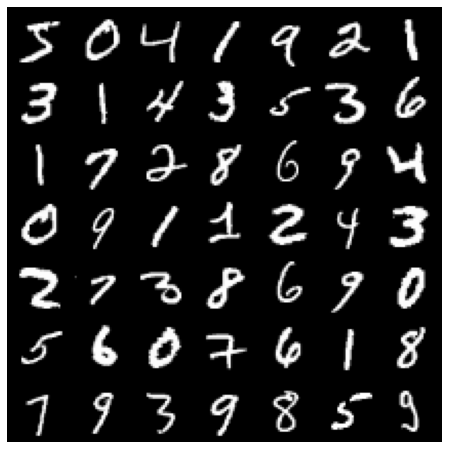

In [ ]:
to_show =[]
for i in range(49):
  to_show.append(mnist_dataset[i][0])

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(make_grid(torch.stack(to_show), nrow=7, normalize=True).permute(1, 2, 0), cmap='gray');

### Define the models

Define the Discriminator network, the Generator network with additional input for condition

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_size, image_pixels, hidden_size, n_classes):
        super(Generator, self).__init__()
        self.embedding = nn.Embedding(n_classes, n_classes)
        self.linear1 = nn.Linear(latent_size + n_classes, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, image_pixels)


    def forward(self, x, y): 
        x = torch.cat([x, self.embedding(y)], 1)
        x = F.leaky_relu(self.linear1(x), 0.2)
        x = F.leaky_relu(self.linear2(x), 0.2)
        x = torch.tanh(self.linear3(x))
        return x


class Discriminator(nn.Module):
    def __init__(self, image_pixels, hidden_size, n_classes):
        super(Discriminator, self).__init__()
        self.embedding = nn.Embedding(n_classes, n_classes)
        self.linear1 = nn.Linear(image_pixels + n_classes, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)

    def forward(self, x, y):
        x = torch.cat([x, self.embedding(y)], 1)
        x = F.leaky_relu(self.linear1(x), 0.2)
        x = F.leaky_relu(self.linear2(x), 0.2)
        x = torch.sigmoid(self.linear3(x))
        return x

In [ ]:
G = Generator(CFG.latent_size, CFG.image_pixels, CFG.hidden_size, CFG.n_classes)
print(G)

D = Discriminator(CFG.image_pixels, CFG.hidden_size, CFG.n_classes)
print(D)

Generator(
  (embedding): Embedding(10, 10)
  (linear1): Linear(in_features=74, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=784, bias=True)
)
Discriminator(
  (embedding): Embedding(10, 10)
  (linear1): Linear(in_features=794, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:
# Let's define loss and optimizers

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=CFG.LR)
g_optimizer = torch.optim.Adam(G.parameters(), lr=CFG.LR)

### Discriminator Training

In [ ]:
def train_discriminator(D_optimizer, D_model, G_model, images, image_classes, latent_size, n_classes, device):
  
    # Create the labels which are later used as input for the BCE loss
    batch_size = images.shape[0]
    real_labels = torch.ones(batch_size).to(device)
    fake_labels = torch.zeros(batch_size).to(device)

    D_optimizer.zero_grad()
    
    outputs = D_model(images, image_classes)
    # Loss for real images
    real_score = outputs.view(-1)
    real_loss = criterion(real_score, real_labels)
    real_loss.backward()

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_classes = torch.randint(0, n_classes, (batch_size,)).to(device)
    fake_images = G_model(z, fake_classes)
    outputs = D_model(fake_images, fake_classes)

    fake_score = outputs.view(-1)
    fake_loss = criterion(fake_score, fake_labels)
    fake_loss.backward()

    d_loss = (real_loss + fake_loss) * 0.5
    D_optimizer.step()
    
    return d_loss, real_score, fake_score

### Generator Training

In [ ]:
def train_generator(G_optimizer, D_model, G_model, latent_size, n_classes, device):
    # Generate fake images and calculate loss
    batch_size = images.shape[0]
    z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    fake_classes = torch.randint(0, n_classes, (batch_size,)).to(device)

    G_optimizer.zero_grad()

    fake_images = G_model(z, fake_classes)
    labels = torch.ones(batch_size).to(device)

    g_loss = criterion(D_model(fake_images, fake_classes).view(-1), labels)

    g_loss.backward()
    G_optimizer.step()

    return g_loss, fake_images

### Start the training proccess

In [ ]:
# function to save the sample output of generator
sample_classes = np.zeros(CFG.n_classes * CFG.n_classes, dtype=int)
for i in range(CFG.n_classes):
  for j in range(CFG.n_classes):
    sample_classes[i * CFG.n_classes + j] = i
sample_classes = torch.from_numpy(sample_classes).to(CFG.device)
sample_vectors = torch.Tensor(np.random.normal(0, 1, (CFG.n_classes * CFG.n_classes, CFG.latent_size))).to(CFG.device)

def save_fake_images_mnist(G_model, index):
    fake_images = G_model(sample_vectors, sample_classes)
    fake_images = fake_images.reshape(fake_images.size(0), 1, CFG.image_size, CFG.image_size)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(denorm(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=10)

In [ ]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(CFG.device)
D.to(CFG.device)
for epoch in range(CFG.num_epochs):
    for i, (images, image_classes) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(CFG.batch_size, -1).to(CFG.device)
        image_classes = image_classes.to(CFG.device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(d_optimizer, D, G, images, image_classes, CFG.latent_size, CFG.n_classes, CFG.device)

        # Train the generator
        g_loss, fake_images = train_generator(g_optimizer, D, G, CFG.latent_size, CFG.n_classes, CFG.device)

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    CFG.num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_mnist(G, epoch + 1)

Epoch [0/300], Step [200/600], d_loss: 0.0854, g_loss: 2.7006, D(x): 0.95, D(G(z)): 0.11
Epoch [0/300], Step [400/600], d_loss: 0.0616, g_loss: 5.9364, D(x): 0.99, D(G(z)): 0.09
Epoch [0/300], Step [600/600], d_loss: 0.1714, g_loss: 3.4119, D(x): 0.88, D(G(z)): 0.13
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0804, g_loss: 4.6656, D(x): 0.90, D(G(z)): 0.03
Epoch [1/300], Step [400/600], d_loss: 0.1346, g_loss: 3.4058, D(x): 0.89, D(G(z)): 0.09
Epoch [1/300], Step [600/600], d_loss: 0.2439, g_loss: 3.3755, D(x): 0.78, D(G(z)): 0.10
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.3015, g_loss: 3.7204, D(x): 0.78, D(G(z)): 0.07
Epoch [2/300], Step [400/600], d_loss: 0.5731, g_loss: 1.7863, D(x): 0.73, D(G(z)): 0.44
Epoch [2/300], Step [600/600], d_loss: 0.5537, g_loss: 1.9280, D(x): 0.58, D(G(z)): 0.25
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.3962, g_loss: 2.0887, D(x): 0.83, D(G(z)): 0.37
Epoch [3/300], Step [400/6

### Show your conditional generation results for every class

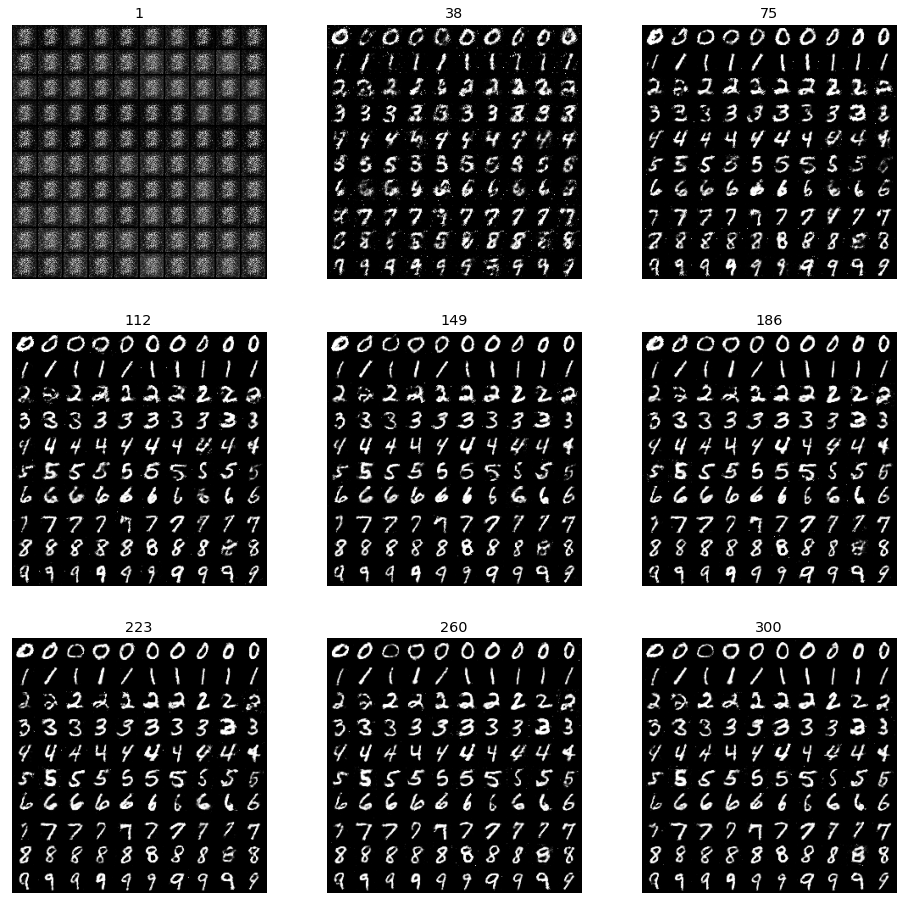

In [ ]:
def read_img(sample_dir, num):
  return mpimg.imread(os.path.join(sample_dir, "fake_images-{0:0=4d}.png".format(num)))

def show_results(sample_dir, num_ehochs):
  images = []
  diff = CFG.num_epochs // 8
  for i in range(1, num_ehochs - diff, diff):
    images.append((read_img(sample_dir, i), i))
  images.append((read_img(sample_dir, num_ehochs), num_ehochs))

  fig = plt.figure(figsize=(16, 16))
  i = 0
  for img, label in images:
    i += 1
    ax = fig.add_subplot(3, 3, i)
    ax.imshow(img)
    ax.set_title(label)
    ax.set_xticks([])
    ax.set_yticks([])

show_results(CFG.sample_dir, CFG.num_epochs)

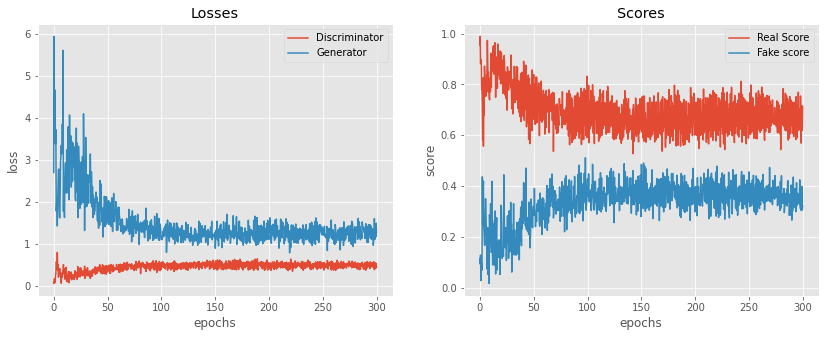

In [ ]:
# show the discrimator loss and generator loss
fig = plt.figure(figsize=(14, 5))
steps = [i / 3 for i in range(len(d_losses))]

ax = fig.add_subplot(1, 2, 1)
ax.plot(steps, d_losses, "-")
ax.plot(steps, g_losses, "-")
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.legend(["Discriminator", "Generator"])
ax.set_title("Losses")

ax = fig.add_subplot(1, 2, 2)
ax.plot(steps, real_scores, "-")
ax.plot(steps, fake_scores, "-")
ax.set_xlabel("epochs")
ax.set_ylabel("score")
ax.legend(["Real Score", "Fake score"])
ax.set_title("Scores");

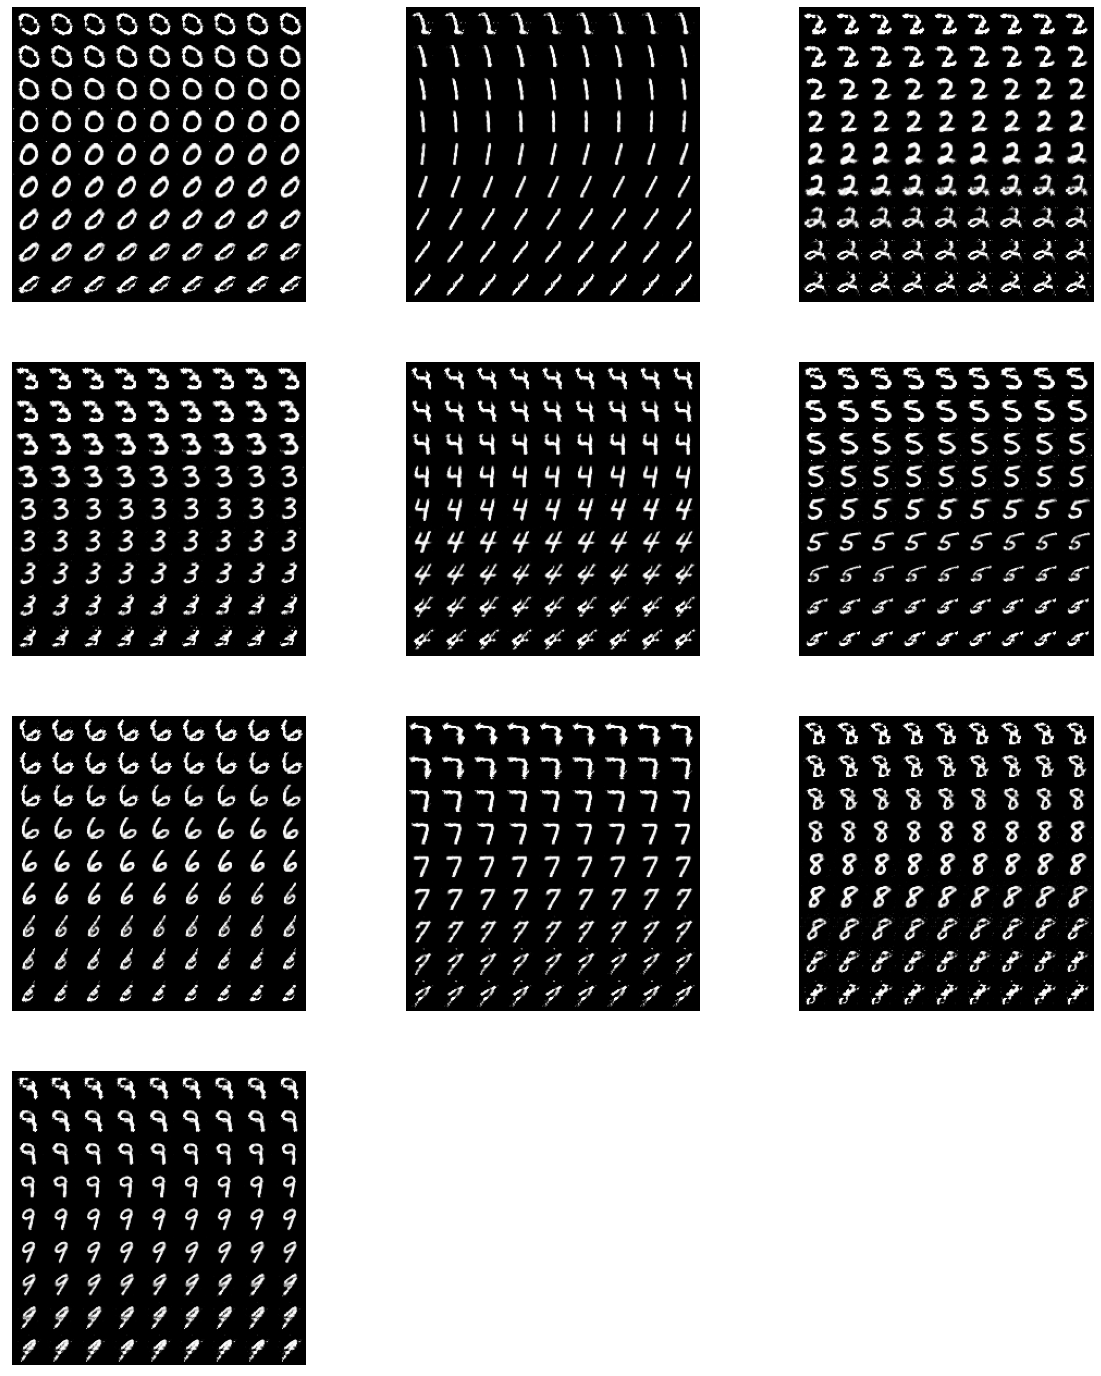

In [ ]:
fig = plt.figure(figsize=(20, 25))

n = 9;
sample_vectors = []
for zi in np.linspace(-2, 2, n * n):
  sample_vectors.append(np.full(CFG.latent_size, zi))

sample_vectors = torch.Tensor(np.array(sample_vectors)).to(CFG.device)

for i in range(10):
  sample_classes = torch.from_numpy(np.full(n * n, i, dtype=int)).to(CFG.device)
  y = G(sample_vectors, sample_classes)

  ax = fig.add_subplot(4, 3, i + 1)
  ax.set_xticks([])
  ax.set_yticks([])

  ax.imshow(make_grid(y.cpu().view(n * n, 1, CFG.image_size, CFG.image_size), nrow=n, normalize=True).permute(1, 2, 0), cmap='gray');